In [54]:
import thesis.jaxdaw as jd
jdist = jd.distributions

from thesis.glitch import GlitchPrior, GlitchModel

import jax
import jax.numpy as jnp
from jax import random, lax

import numpyro
import numpyro.distributions as ndist
from numpyro.infer import NUTS, MCMC, Trace_ELBO, SVI
from numpyro.infer.autoguide import AutoIAFNormal
from numpyro.infer.reparam import NeuTraReparam

import optax

import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')
numpyro.set_host_device_count(10)

In [2]:
name = "better"
df = pd.read_csv(f"data/glitch-inputs-{name}.csv")
df.head()

,n,l,nu_true,nu,nu_err
0,15,0,2180.124902,2180.160168,0.1
1,16,0,2312.029479,2312.001039,0.1
2,17,0,2442.808410,2442.644690,0.1
3,18,0,2574.262983,2574.324094,0.1
4,19,0,2706.595870,2706.495193,0.1


In [3]:
n, nu, nu_err = df.n.to_numpy(), df.nu.to_numpy(), df.nu_err.to_numpy()

# delta_nu, epsilon = estimate_asy(n, nu, nu_err=nu_err)
delta_nu = jdist.Normal(132.8, 0.1)
epsilon = jdist.Normal(1.4, 0.05)
prior = GlitchPrior(delta_nu, epsilon)
model = GlitchModel(prior, n=n, nu=nu, nu_err=nu_err)

print(f"{delta_nu.mean:.2f} ± {delta_nu.variance**0.5:.2f}")
print(f"{epsilon.mean:.2f} ± {epsilon.variance**0.5:.2f}")

132.80 ± 0.10
1.40 ± 0.05


In [4]:
pyro_prior = {}
for k, v in prior.distributions.items():
    if isinstance(v, jdist.Normal):
        pyro_prior[k] = ndist.Normal(v.loc, v.scale)

In [106]:
def pyro_model():
    params = {}
    for k, v in pyro_prior.items():
        params[k] = numpyro.sample(k, v)
    
    phi_dist = ndist.Uniform(0.0, 2 * jnp.pi)
    _phi = numpyro.sample("_phi", ndist.ImproperUniform(ndist.constraints.real, (), (2,)))
    phi = jnp.remainder(_phi, 2 * jnp.pi)
    params["phi_he"] = numpyro.deterministic("phi_he", phi[0])
    params["phi_cz"] = numpyro.deterministic("phi_cz", phi[1])
    numpyro.factor(f"_phi_logp", phi_dist.log_prob(phi).sum())
    
    gp = model.build_gp(params)
    numpyro.sample("nu", gp.numpyro_dist(), obs=model.nu) 

In [107]:
# guide = AutoBNAFNormal(pyro_model, hidden_factors=[8, 8, 8, 8])
# # optim = numpyro.optim.Adam(0.003)
# optim = optax.adam(0.1)
# svi = SVI(pyro_model, guide, optim, Trace_ELBO())

In [108]:
# rng = random.PRNGKey(0)
# rng, key = random.split(rng)
# svi_result = svi.run(key, 10000)

In [109]:
# plt.plot(svi_result.losses)
# plt.yscale("log")

In [110]:
# neutra = NeuTraReparam(guide, svi_result.params)
# sampler = NUTS(neutra.reparam(pyro_model), target_accept_prob=0.8)
# mcmc = MCMC(sampler, num_warmup=500, num_samples=1000, num_chains=10)

In [111]:
# rng, key = random.split(rng)
# mcmc.run(key)

In [112]:
# mcmc.print_summary(exclude_deterministic=False)

In [113]:
sampler = NUTS(pyro_model, target_accept_prob=0.9)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=10)

In [114]:
# %%time
rng = random.PRNGKey(0)
rng, key = random.split(rng)
mcmc.run(key)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [120]:
mcmc.print_summary(exclude_deterministic=False)


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
       _phi[0]      1.08      5.69      0.52     -6.62     10.49      6.06      2.51
       _phi[1]     28.73   1345.12    -98.57  -2298.56   1965.66      5.57      4.85
      delta_nu    132.81      0.10    132.81    132.65    132.96   1121.10      1.01
       epsilon      1.41      0.03      1.41      1.36      1.47    899.57      1.01
  log_alpha_cz      8.53      0.55      8.63      7.69      9.37    841.62      1.01
  log_alpha_he    -11.11      0.20    -11.10    -11.44    -10.78    541.45      1.02
   log_beta_he    -15.02      0.17    -15.02    -15.30    -14.74    586.39      1.02
     log_sigma     -4.81      1.79     -4.70     -7.52     -1.83    964.82      1.01
    log_tau_cz     -6.13      0.16     -6.10     -6.50     -5.96    293.86      1.03
    log_tau_he     -7.33      0.10     -7.34     -7.49     -7.17    456.57      1.02
        phi_cz      3.19      1.81      3.22      0.63      6.24

In [115]:
data = az.from_numpyro(mcmc)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

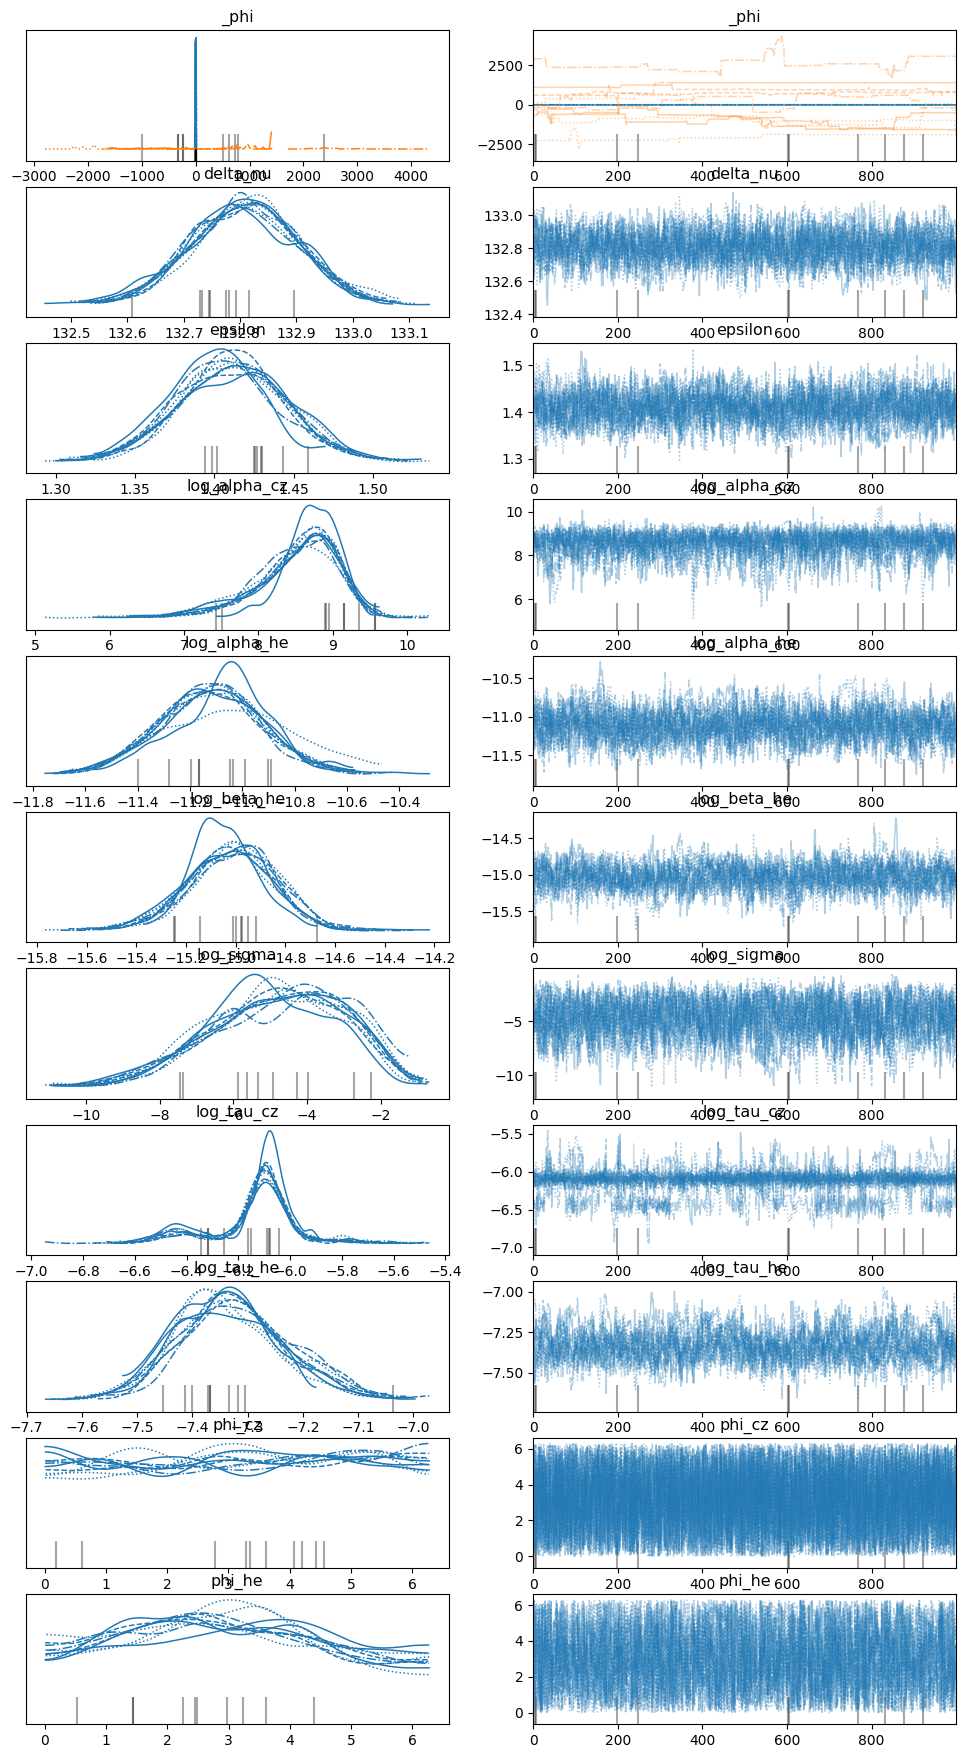

In [116]:
az.plot_trace(data);

In [117]:
samples = mcmc.get_samples()

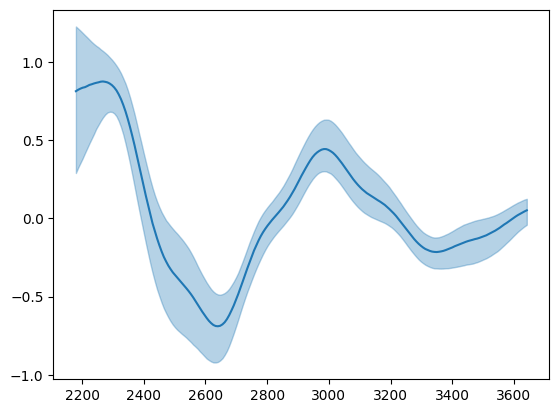

In [118]:
model.plot_glitch(samples, intervals=[(.16, .84)]);

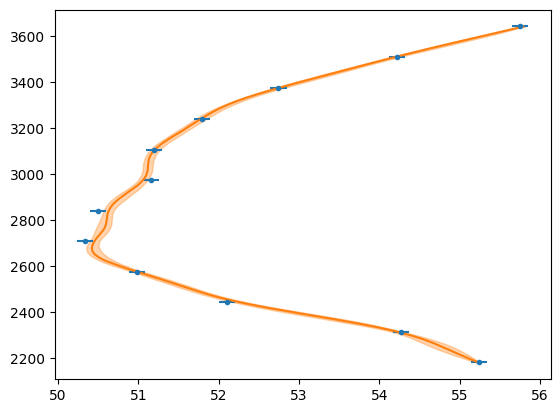

In [119]:
rng, key = random.split(key)
model.plot_echelle(key, samples, intervals=[(.16, .84)]);